# Assignment 5 - Reinforcement Learning

## *Bingying Liu*
Netid:  *bl199*

### Blackjack

Your goal is to develop a reinforcement learning technique to learn the optimal policy for winning at blackjack. Here, we're going to modify the rules from traditional blackjack a bit in a way that corresponds to the game presented in Sutton and Barto's *Reinforcement Learning: An Introduction* (Chapter 5, example 5.1). A full implementation of the game is provided and usage examples are detailed in the class header below.

The rules of this modified version of the game of blackjack are as follows:

- Blackjack is a card game where the goal is to obtain cards that sum to as near as possible to 21 without going over.  We're playing against a fixed (autonomous) dealer.
- Face cards (Jack, Queen, King) have point value 10. Aces can either count as 11 or 1, and we're refer to it as 'usable' at 11 (indicating that it could be used as a '1' if need be. This game is placed with a deck of cards sampled with replacement.
- The game starts with each (player and dealer) having one face up and one face down card.
- The player can request additional cards (hit, or action '1') until they decide to stop (stay, action '0') or exceed 21 (bust, the game ends and player loses).
- After the player stays, the dealer reveals their facedown card, and draws until their sum is 17 or greater. If the dealer goes bust the player wins. If neither player nor dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21.  The reward for winning is +1, drawing is 0, and losing is -1.



You will accomplish three things:
1. Try your hand at this game of blackjack and see what your human reinforcement learning system is able to achieve
2. Evaluate a simple policy using Monte Carlo policy evaluation
3. Determine an optimal policy using Monte Carlo control

*This problem is adapted from David Silver's [excellent series on Reinforcement Learning](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html) at University College London*

## 1

### [10 points] Human reinforcement learning 

Using the code detailed below, play 50 hands of blackjack, and record your overall average reward. This will help you get accustomed with how the game works, the data structures involved with representing states, and what strategies are most effective.

In [22]:
import numpy as np

class Blackjack():
    """Simple blackjack environment adapted from OpenAI Gym:
        https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py
    
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with a deck sampled with replacement.
    
    The game starts with each (player and dealer) having one face up and one
    face down card.
    
    The player can request additional cards (hit = 1) until they decide to stop
    (stay = 0) or exceed 21 (bust).
    
    After the player stays, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    
    The observation is a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto (1998).
    
    http://incompleteideas.net/sutton/book/the-book.html
    
    Usage: 
        Initialize the class:
            game = Blackjack()
        
        Deal the cards:
            game.deal()
            
             (14, 3, False)
             
            This is the agent's observation of the state of the game:
            The first value is the sum of cards in your hand (14 in this case)
            The second is the visible card in the dealer's hand (3 in this case)
            The Boolean is a flag (False in this case) to indicate whether or 
                not you have a usable Ace
            (Note: if you have a usable ace, the sum will treat the ace as a 
                value of '11' - this is the case if this Boolean flag is "true")
            
        Take an action: Hit (1) or stay (0)
        
            Take a hit: game.step(1)
            To Stay:    game.step(0)
            
        The output summarizes the game status:
            
            ((15, 3, False), 0, False)
            
            The first tuple (15, 3, False), is the agent's observation of the
            state of the game as described above.
            The second value (0) indicates the rewards
            The third value (False) indicates whether the game is finished
    """
    
    def __init__(self):
        # 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
        self.deck   = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
        self.dealer = []
        self.player = []
        self.deal()

    def step(self, action):
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card())
            if self.is_bust(self.player):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else:  # stay: play out the dealers hand, and score
            done = True
            while self.sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            reward = self.cmp(self.score(self.player), self.score(self.dealer))
        return self._get_obs(), reward, done

    def _get_obs(self):
        return (self.sum_hand(self.player), self.dealer[0], self.usable_ace(self.player))

    def deal(self):
        self.dealer = self.draw_hand()
        self.player = self.draw_hand()
        return self._get_obs()
    
    #------------------------------------------
    # Other helper functions
    #------------------------------------------
    def cmp(self, a, b):
        return float(a > b) - float(a < b)
    
    def draw_card(self):
        return int(np.random.choice(self.deck))
    
    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]
    
    def usable_ace(self,hand):  # Does this hand have a usable ace?
        return 1 in hand and sum(hand) + 10 <= 21
    
    def sum_hand(self,hand):  # Return current hand total
        if self.usable_ace(hand):
            return sum(hand) + 10
        return sum(hand)
    
    def is_bust(self,hand):  # Is this hand a bust?
        return self.sum_hand(hand) > 21
    
    def score(self,hand):  # What is the score of this hand (0 if bust)
        return 0 if self.is_bust(hand) else self.sum_hand(hand)

Here's an example of how it works to get you started:

**ANSWER**

In [26]:
# Initialize the class:
game = Blackjack()

win_count = 0
draw_count = 0
num_games = 50

# Play 50 games
for i in range(1,num_games+1):
    
    # Deal the cards:
    s0 = game.deal()
    print("\nStart of game {}: Player sum {}, Dealer Card {}, Usable Ace {}".format(i,s0[0],s0[1],s0[2])) 
    
    for t in range(100):
        action = input("Enter action <hit=1, stay=0>: ")
        # Take an action: Hit = 1 or stay = 0.
        s1 = game.step(int(action))
        print("State of World: {}".format(s1))
        if s1[2] == True:
            if s1[1] == 1:
                print("Win")
                win_count += 1
            elif s1[1] == 0:
                print("Draw")
                draw_count += 1
            else:
                print("Lose")
            break

print("\nGAME SUMMARY")
print("Win Count: ",win_count)
print("Draw Count: ",draw_count)
print("Lose Count: ",num_games - (draw_count+win_count))
print("% Win = ",win_count/float(num_games))


Start of game 1: Player sum 6, Dealer Card 4, Usable Ace False
Enter action <hit=1, stay=0>: 1
State of World: ((17, 4, True), 0, False)
Enter action <hit=1, stay=0>: 0
State of World: ((17, 4, True), 1.0, True)
Win

Start of game 2: Player sum 14, Dealer Card 3, Usable Ace False
Enter action <hit=1, stay=0>: 1
State of World: ((18, 3, False), 0, False)
Enter action <hit=1, stay=0>: 0
State of World: ((18, 3, False), -1.0, True)
Lose

Start of game 3: Player sum 21, Dealer Card 3, Usable Ace True
Enter action <hit=1, stay=0>: 0
State of World: ((21, 3, True), 1.0, True)
Win

Start of game 4: Player sum 9, Dealer Card 6, Usable Ace False
Enter action <hit=1, stay=0>: 1
State of World: ((19, 6, False), 0, False)
Enter action <hit=1, stay=0>: 0
State of World: ((19, 6, False), 1.0, True)
Win

Start of game 5: Player sum 20, Dealer Card 2, Usable Ace False
Enter action <hit=1, stay=0>: 0
State of World: ((20, 2, False), 1.0, True)
Win

Start of game 6: Player sum 15, Dealer Card 8, Usable

Enter action <hit=1, stay=0>: 1
State of World: ((24, 8, False), -1, True)
Lose

Start of game 43: Player sum 15, Dealer Card 10, Usable Ace False
Enter action <hit=1, stay=0>: 1
State of World: ((17, 10, False), 0, False)
Enter action <hit=1, stay=0>: 0
State of World: ((17, 10, False), 0.0, True)
Draw

Start of game 44: Player sum 16, Dealer Card 10, Usable Ace False
Enter action <hit=1, stay=0>: 1
State of World: ((26, 10, False), -1, True)
Lose

Start of game 45: Player sum 6, Dealer Card 3, Usable Ace False
Enter action <hit=1, stay=0>: 1
State of World: ((8, 3, False), 0, False)
Enter action <hit=1, stay=0>: 1
State of World: ((18, 3, False), 0, False)
Enter action <hit=1, stay=0>: 0
State of World: ((18, 3, False), 1.0, True)
Win

Start of game 46: Player sum 16, Dealer Card 10, Usable Ace False
Enter action <hit=1, stay=0>: 1
State of World: ((26, 10, False), -1, True)
Lose

Start of game 47: Player sum 19, Dealer Card 3, Usable Ace False
Enter action <hit=1, stay=0>: 0
State o

Win Count = 22 <br>
Draw Count = 4 <br>
Lose Count = 24 <br>
Total Games =50 <br>
Percentage of winning = 22/50 = 0.44 <br>
Overall average reward = $\frac{22*1+4*0+24*(-1)}{50}$ = -0.04.

# 2

### [40 points] Perform Monte Carlo Policy Evaluation

Thinking that you want to make your millions playing blackjack, you decide to test out a policy for playing this game. Your idea is an aggressive strategy: always hit unless the total of your cards adds up to 20 or 21, in which case you stay.

**(a)** Use Monte Carlo policy evaluation to evaluate the expected returns from each state. Create plots for these similar to Sutton and Barto, Figure 5.1 where you plot the expected returns for each state. In this case create 2 plots:
1. When you have a useable ace, plot the state space with the dealer's card on the x-axis, and the player's sum on the y-axis, and use the 'RdBu' matplotlib colormap and `imshow` to plot the value of each state under the policy described above. The domain of your x and y axes should include all possible states (2 to 21 for the player sum, and 1 to 10 for the dealer's card). Do this for for 10,000 episodes.
2. Repeat (1) for the states without a usable ace.
3. Repeat (1) for the case of 500,000 episodes.
4. Relwat (2) for the case of 500,000 episodes.

**(b)** Show a plot of the overall average reward per episode vs the number of episodes. For both the 10,000 episode case and the 500,000 episode case, record the overall average reward for this policy and report that value. 

**ANSWER**

**(a)**

In [27]:
from collections import defaultdict
import matplotlib.pyplot as plt

In [28]:
def policy(observation):
    score, dealer_score, usable_ace = observation
    # Stick if the score is > 20, hit otherwise
    return 0 if score >= 20 else 1

In [29]:
def MC_evaluate(game, policy, episode_num):
    """
    MC_evaluate function takes in 
    *game: an instance of Class Blackjack
    *policy: policy defined above (action of 0/1)
    *episode_num: number of episodes for convergence
    and outputs
    *V: average reward of each state after policy evaluation
    *average_reward_per_episode: total reward/number of episodes
    """

    V = defaultdict(float)  #arbitrary state value function: V = {state: average reward}
    Returns = defaultdict(float) #store the returns for each state: Returns = {state: total rewards}
    Returns_cnt = defaultdict(float) #store the number of times the state was visited: Returns_cnt = {state: count}

    average_reward_per_episode = []
    total_reward = 0
    
    for i_episode in range(1, episode_num+1):

        ## Step 1: Generate Episode
        curr_state = game.deal()
        episode = []       
        
        for t in range(100):
            action = policy(curr_state)
            next_state,reward,done = game.step(action)
            episode.append((curr_state, reward))
            if done:
                total_reward += reward
                break
            curr_state = next_state
        
        average_reward_per_episode.append(total_reward/i_episode)
            
        ## Step 2: Update Values and Returns
        
        for i in range(len(episode)):
            state,reward = episode[i]
            Returns[state] += episode[-1][1]
            Returns_cnt[state] += 1
            V[state] = Returns[state]/Returns_cnt[state]
        
    return V, average_reward_per_episode

In [30]:
# Initialize a Blackjack game
bjack_game = Blackjack()

V_10k, avg_reward_10k = MC_evaluate(bjack_game, policy, 10000)
V_500k, avg_reward_500k = MC_evaluate(bjack_game, policy, 500000)
print("Done running predictions")

Done running predictions


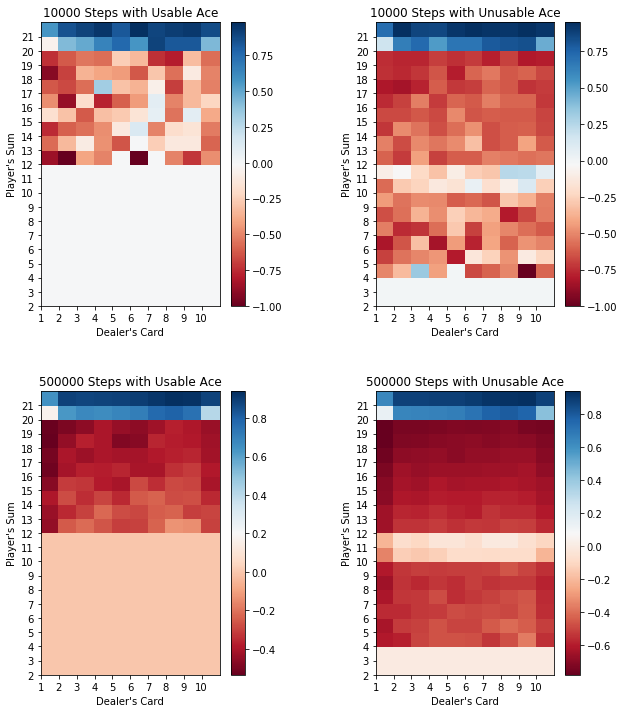

In [31]:
x = np.arange(1, 12, 1)  # Dealer's card
y = np.arange(2, 23, 1) # Player's sum
X, Y = np.meshgrid(x, y)

# 10k: 'usable_Ace = True'
z10k_usable = np.array([V_10k[(y,x,True)] for (x,y) in zip(np.ravel(X), np.ravel(Y))])
Z10k_usable = z10k_usable.reshape(X.shape)

# 10k: 'usable_Ace = False'
z10k_unusable = np.array([V_10k[(y,x,False)] for (x,y) in zip(np.ravel(X), np.ravel(Y))])
Z10k_unusable = z10k_unusable.reshape(X.shape)

# 50k: 'usable_Ace = True'
z500k_usable = np.array([V_500k[(y,x,True)] for (x,y) in zip(np.ravel(X), np.ravel(Y))])
Z500k_usable = z500k_usable.reshape(X.shape)

# 50k：'usable_Ace = False'
z500k_unusable = np.array([V_500k[(y,x,False)] for (x,y) in zip(np.ravel(X), np.ravel(Y))])
Z500k_unusable = z500k_unusable.reshape(X.shape)

plt.figure(figsize=(10,12))

## Plotting 10k and 500k prediction results
avg_values = {10000:[Z10k_usable, Z10k_unusable], 500000:[Z500k_usable, Z500k_unusable]}
use_ace = ['Usable', 'Unusable']
counter = 0
for key, value in avg_values.items():
    for avg_value in value:
        plt.subplot(int('22' + str(counter+1) ))
    
        plt.xlabel("Dealer's Card")
        plt.ylabel("Player's Sum")
        plt.yticks(np.arange(2, 22, 1))
        plt.xticks(np.arange(1, 11, 1))
        if key == 10000:       
            plt.title("10000 Steps with {} Ace".format(use_ace[counter%2]))
        else: 
            plt.title("500000 Steps with {} Ace".format(use_ace[counter%2]))
        plt.pcolor(X,Y,avg_value, cmap='RdBu')
        plt.colorbar()
        counter += 1
        
plt.subplots_adjust(wspace=.5, hspace=.3)
plt.show()   

From the plots above, we can see that the cases using 10k episodes are not completely settled since there are some random combinations of positive rewards when player's sum is between 12 and 19. However, 50K episodes ensure convergence. Difference between 'usable ace' and 'no usable ace' case is that no value less than or equal to 12 is visited in 'usable ace'. (impossible to get 2 ace as the game rules out this possiblity)

**(b) Average reward per episode VS the number of episodes**

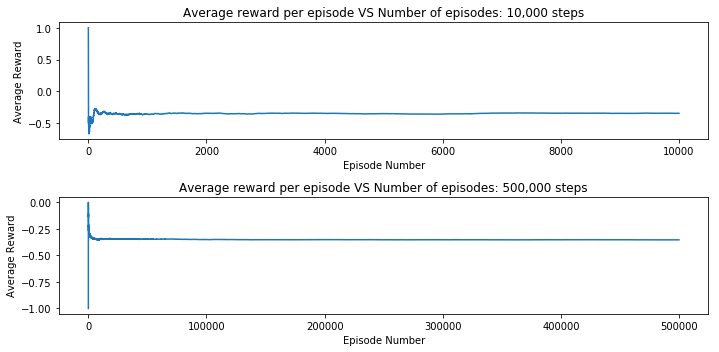

In [32]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title("Average reward per episode VS Number of episodes: 10,000 steps")
plt.ylabel("Average Reward")
plt.xlabel("Episode Number")
plt.plot(range(0, len(avg_reward_10k)), [reward for reward in avg_reward_10k])


plt.subplot(2,1,2)
plt.title("Average reward per episode VS Number of episodes: 500,000 steps")
plt.ylabel("Average Reward")
plt.xlabel("Episode Number")
plt.plot(range(0,len(avg_reward_500k)), [reward for reward in avg_reward_500k])

plt.tight_layout()
plt.show()

In [33]:
print('Overall average reward for this policy with 10,000 episodes is %f'% (np.sum(np.array(avg_reward_10k))/len(avg_reward_10k)))
print('Overall average reward for this policy with 500,000 episodes is %f'% (np.sum(np.array(avg_reward_500k))/len(avg_reward_500k)))

Overall average reward for this policy with 10,000 episodes is -0.346969
Overall average reward for this policy with 500,000 episodes is -0.351161


Since policy is fixed for MC evaluation, average reward (except for the first few episodes which haven't converged yet) is static. Also average reward per episode in 10,000 steps (-0.355) and 500,000 steps (-0.352) are similar.

## 3

### [40 points] Perform Monte Carlo Control

**(a)** Using Monte Carlo Control through policy iteration, estimate the optimal policy for playing our modified blackjack game to maximize rewards. 

In doing this, use the following assumptions:
1. Initialize the value function and the state value function to all zeros
2. Keep a running tally of the number of times the agent visited each state and chose an action. $N(s_t,a_t)$ is the number of times action $a$ has been selected from state $s$. You'll need this to compute the running average. You can implement an online average as: $\bar{x}_{t} = \frac{1}{N}x_t + \frac{N-1}{N}\bar{x}_{t-1}$ 
3. Use an $\epsilon$-greedy exploration strategy with $\epsilon_t = \frac{N_0}{N_0 + N(s_t)}$, where we define $N_0 = 100$. Vary $N_0$ as needed.

Show your result by plotting the optimal value function: $V^*(s) = max_a Q^*(s,a)$ and the optimal policy $\pi^*(s)$. Create plots for these similar to Sutton and Barto, Figure 5.2 in the new draft edition, or 5.5 in the original edition. Your results SHOULD be very similar to the plots in that text. For these plots include:
1. When you have a useable ace, plot the state space with the dealer's card on the x-axis, and the player's sum on the y-axis, and use the 'RdBu' matplotlib colormap and `imshow` to plot the value of each state under the policy described above. The domain of your x and y axes should include all possible states (2 to 21 for the player sum, and 1 to 10 for the dealer's visible card).
2. Repeat (1) for the states without a usable ace.
3. A plot of the optimal policy $\pi^*(s)$ for the states with a usable ace (this plot could be an imshow plot with binary values).
4. A plot of the optimal policy $\pi^*(s)$ for the states without a usable ace (this plot could be an imshow plot with binary values).

**(b)** Show a plot of the overall average reward per episode vs the number of episodes. What is the average reward your control strategy was able to achieve?

*Note: convergence of this algorithm is extremely slow. You may need to let this run a few million episodes before the policy starts to converge. You're not expected to get EXACTLY the optimal policy, but it should be visibly close.* 

**ANSWER**

**(a) Monte Carlo Control through policy iteration**

In [23]:
import random
import sys

def policy_fn(Policy, state, epsilon):    
    """
    policy_fn function takes in 
    *Policy: {state: 0/1} (policy updated for each episode), 
    *state: (Player's sum, Dealer's card, Useable Ace) and
    *epsilon: float (uncertainty for exploration)
    and outputs
    *action that should be taken under the state (balance between exploration and exploitation)
    """
    
    a_best = Policy[state] #look up the best policy of one state
    a_other = 1 - a_best

    num = random.uniform(0, 1)
    return a_other if num <= epsilon else a_best
    
def Monte_Carlo_Control(game, policy_fn, num_episodes):
    """
    Monte_Carlo_Control function takes in
    *game: an instance of Class Blackjack
    *policy_fn: policy_fn function
    *num_episodes: number of episodes for convergence
    
    and outputs
    *Q: {(state, action):average reward}
    *Policy: optimum policy {state: 0/1}
    *average_reward_per_episode: a list of average reward per episode
    *running_overall_average_reward: total reward/number of episodes
    """

    Q = defaultdict(float) # action value function dictionary: Q={(state, action):average reward}
    Returns = defaultdict(float)  # Returns = {(state, action): rewards}
    Returns_cnt = defaultdict(float) # Returns_cnt = {(state, action): times}
    Policy = defaultdict(float) # Prescribed policy for one state: Policy = {state: 0/1}
    
    average_reward_per_episode = []
    running_overall_average_reward = []
    total_reward = 0
    
    for i_episode in range(1, num_episodes+1):
        
        # Print out every episode
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        ## Step 1: Generate Episode

        curr_state = game.deal()
        episode = []          # An episode is an array of (state, reward, action) tuples
        total_episode_reward = 0
        counter = 0
        
        for t in range(100):
            # Determine action based on current policy function
            # Calculate eqsilon
            N_0 = 100.
            N_st = Returns_cnt[(curr_state,1)] + Returns_cnt[(curr_state,0)]
            eps = N_0/(N_0 + N_st)
            action = policy_fn(Policy, curr_state, eps)

            next_state,reward,done = game.step(action)
            
            total_episode_reward += reward
            counter += 1         
            episode.append((curr_state, reward, action))

            if done:
                total_reward += reward
                break

            curr_state = next_state

        # Save average reward for this episode
        average_reward_per_episode.append(total_episode_reward/float(counter))
        running_overall_average_reward.append(total_reward/i_episode)
        
        ## Step 2: Update Q(s,a), which is the action value dictionary
        
        for i in range(len(episode)):
            state,reward,action = episode[i]

            Returns[(state,action)] += episode[-1][1]
            Returns_cnt[(state,action)] += 1
            Q[(state,action)] = Returns[(state,action)]/Returns_cnt[(state,action)]
        
        ## Step 3: Update policy according to new Q
        
        for i in range(len(episode)):
            state,_,_ = episode[i]
            a_best = 1 if Q[(state,1)] > Q[(state,0)] else 0
            Policy[state] = a_best
            
    return Q,Policy,average_reward_per_episode,running_overall_average_reward

# Initialize a Blackjack game
bjack_game = Blackjack()

print("Running Monte Carlo Control")
Q,policy,avg_reward,running_avg = Monte_Carlo_Control(bjack_game, policy_fn, 18000000)
print("Done")

Running Monte Carlo Control
Episode 18000000/18000000.Done


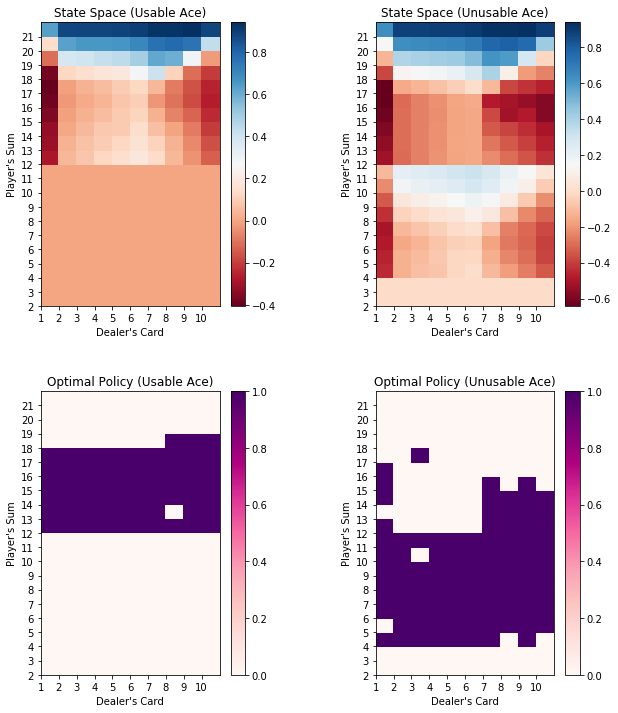

In [24]:
x = np.arange(1, 12, 1)
y = np.arange(2, 23, 1)
X, Y = np.meshgrid(x, y)

# action value function: 'usable_Ace = True'
q_usable = np.maximum(np.array([Q[((y,x,True),0)] for (x,y) in zip(np.ravel(X), np.ravel(Y))]), np.array([Q[((y,x,True),1)] for (x,y) in zip(np.ravel(X), np.ravel(Y))])) 
Q_usable = q_usable.reshape(X.shape)

# action value function: 'usable_Ace = False'
q_unusable = np.maximum(np.array([Q[((y,x,False),0)] for (x,y) in zip(np.ravel(X), np.ravel(Y))]), np.array([Q[((y,x,False),1)] for (x,y) in zip(np.ravel(X), np.ravel(Y))])) 
Q_unusable = q_unusable.reshape(X.shape)

# Policy fn: unusable ace
pol_unusable = np.array([policy_fn(policy, (y,x,False), 0.015) for (x,y) in zip(np.ravel(X), np.ravel(Y))])
Policy_unusable = pol_unusable.reshape(X.shape)

# Policy fn: usable ace
pol_usable = np.array([policy_fn(policy, (y,x,True),0.015) for (x,y) in zip(np.ravel(X), np.ravel(Y))])
Policy_usable = pol_usable.reshape(X.shape)

plt.figure(figsize=(10,12))

## Plotting state space and optimal policy plots
avg_values = {1:[Q_usable, Q_unusable], 2:[Policy_usable, Policy_unusable]}
use_ace = ['Usable', 'Unusable']
counter = 0
for key, value in avg_values.items():
    for avg_value in value:
        plt.subplot(int('22' + str(counter+1) ))
    
        plt.xlabel("Dealer's Card")
        plt.ylabel("Player's Sum")
        plt.yticks(np.arange(2, 22, 1))
        plt.xticks(np.arange(1, 11, 1))
        if key == 1:       
            plt.title("State Space ({} Ace)".format(use_ace[counter%2]))
            plt.pcolor(X,Y,avg_value, cmap='RdBu')
        else: 
            plt.title("Optimal Policy ({} Ace)".format(use_ace[counter%2]))
            plt.pcolor(X,Y,avg_value, cmap='RdPu')
        plt.colorbar()
        counter += 1
        
plt.subplots_adjust(wspace=.5, hspace=.3)
plt.show()   

**Note**: For plot above, purple region is "hit" region (actoin = 1) while white region is "stay" region (action = 0). Since with 18 million episodes, the MC control model hasn't converged, the plot especially for optimal policy is somewhat different from fig from book.

**(b) Overall average reward per episode vs Number of episodes**

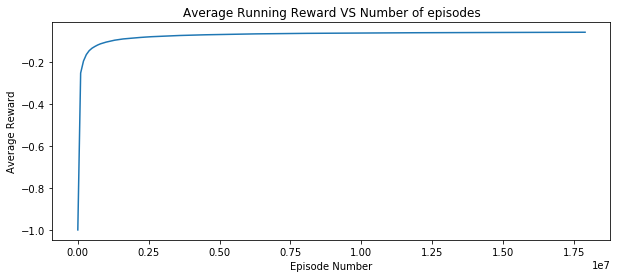

Overall Average Reward is  -0.047005725198412604


In [25]:
plt.figure(figsize=(10,4))
plt.title("Average Running Reward VS Number of episodes")
plt.ylabel("Average Reward")
plt.xlabel("Episode Number")
plt.plot(range(0,len(running_avg),100000), [running_avg[i] for i in range(0,len(running_avg),100000)])
plt.show()

# Calculate overall average rewards for 18 million episodes
overall_avg_reward = np.sum(np.array(avg_reward))/float(len(avg_reward))
print("Overall Average Reward is ", overall_avg_reward)

Since MC control is a learning process, the average running reward picture is completely different from MC evaluation's. The picture shows as number of episode increases, the average running reward converges to number close to zeros. However, the result we got from running 18 milion episodes is still not optimal, we could potentially get an optimal average reward when model converges.

## 4

### [10 points] Discuss your findings

Compare the performance of your human control policy, the naive policy from question 2, and the optimal control policy in question 3. 
**(a)** Which performs best? Why is this the case? 
**(b)** Could you have created a better policy if you knew the full Markov Decision Process for this environment? Why or why not?

**ANSWER**

**(a) Human Control Policy, the Naive Policy, the Optimal Policy, which performs the best?**

Comparing overall average reward, we can see that my human control policy is really good (kind of siulating the exploration vs. exploitation strategy) with -0.04 average reward while MC Evalutaion has an average reward of -0.35, MC Control -0.047. However, the fact that I might be a good blackjack player doesn't mean that I can play that many episodes of blackjack as computer can do within an hour. So, I still think Monte Carlo Control policy performs the best (taken into account that this model currently hasn't converged yet).

**(b) Could you have created a better policy if you knew the full Markov Decision Process for this environment?**

Yes, I could have created a better policy. MDP means current state given to the agent completely characterizes the environment, so agent knows all there is to know about the environment, which is the ideal case. Full MDP assumes the knowledge of state, space, state transition probabilities, reward function and discounting factors. With the knowledge of MDP, we could actually simulate actions without actually taking them. We also know the probability distribution associated with calculating optimal policy (state value and action value functions) without estimation.